In [1]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### data reader

In [2]:
data_dict, int_label_pos_map = load_data_dict(
    mat_path, patients_list, phase_labels, param_keys_list
)

### sandbox

In [ ]:
patient = 'Pat_02'
phase = 'taskLearn'
#
corr_net_filt = dict(threshold=0)
#
data_pat_phase = data_dict[patient][phase]
data_pat_phase_ts = data_pat_phase['data']
fs = data_pat_phase['fs']
filter_order = data_pat_phase['filter_order']

In [ ]:
# Use the function from corrmat module to build correlation matrices per band
corr_mat_band_tw = build_corrmat_perband(
    data_pat_phase_ts, 
    fs, 
    return_jump_info=False,
    apply_threshold_filtering=False,
    corr_network_params=corr_net_filt
)

In [ ]:
fig, ax = plt.subplots(1, len(BRAIN_BANDS), figsize=(20, 6))
#
for i, (band_name, corr_mat) in enumerate(corr_mat_band_tw.items()):
    G = nx.from_numpy_array(corr_mat)
    #
    widths = [ G[u][v]['weight'] for u, v in G.edges()]
    edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G.edges(data=True)]
    nx.draw(G, ax=ax[i], node_size=100, width=widths, edge_color=edge_colors, with_labels=True, labels=int_label_pos_map[patient]['label'],font_size=8)
#
# kwargs_imshow = dict(cmap='viridis', interpolation='none', vmin=C_tmp.min(), vmax=C_tmp.max())
# im = ax[2].imshow(C_tmp, **kwargs_imshow)
# div, cax, clb = imshow_colorbar_caxdivider(im, ax[2])

## First exploration: Pre-Post-Task differences per bands
Select a `patient`, then compute for each one the correlation matrix $C_{ij}^{\rm phase}$ per phase.
Here the objective is to compare if there is a form of persistence in different bands across one subject with respect to the different phases.
It would be relevant to link this persistance to something related to the performance of the specific task. Would a Motor task have the same parsitence than this cognitive one?

In [3]:
patient = 'Pat_02'
correlation_protocol = dict(threshold=0,spectral_cleaning=False)
#
data_pat = data_dict[patient]
#
path_figs = Path('data') / 'figures' / 'per_patient_preVSpost'
path_figs.mkdir(parents=True, exist_ok=True)
# FIX: Create filtered labels dictionary for only remaining nodes
all_labels = int_label_pos_map[patient]['label']
#
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=True)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='top')

### interactive

In [ ]:
from ipywidgets import interact, FloatSlider

custom_th = None
jump_num = 0

corr_mat = build_corr_network(
    data_pat_phase_ts,
    **correlation_protocol
)
Th, jumps = find_threshold_jumps(nx.from_numpy_array(corr_mat))

# Prepare data for interactive visualization
corr_mat_tmp = corr_mat.copy()
corr_mat_tmp[corr_mat_tmp < Th[jumps[jump_num]]] = 0
G, removed_nodes = get_giant_component_leftoff(nx.from_numpy_array(corr_mat_tmp))
labeldict = {k: v for k, v in all_labels.to_dict().items() if k not in removed_nodes}

spect, L, rho, Trho, tau = compute_laplacian_properties(G, tau=None)
dists = squareform(Trho)
lnkgM, label_list, _ = compute_normalized_linkage(dists, G, method='ward')
clTh, *_ = compute_optimal_threshold(lnkgM, scaling_factor=0.98)
clTh = custom_th or clTh

node_list = list(G.nodes())
labels_for_dendro = [labeldict[n] for n in node_list]
widths = [G[u][v]['weight'] for u, v in G.edges()]
edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G.edges(data=True)]

def plot_dendro_and_graph(clTh):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
    
    # Dendrogram first (to get the leaf colors)
    dendro = dendrogram(
        lnkgM,
        ax=ax[0],
        color_threshold=clTh,
        labels=labels_for_dendro,
        **kw_dentro
    )
    tmin = lnkgM[:, 2][0] * 0.8
    tmax = lnkgM[:, 2][-1] * 1.01
    ax[0].set_yscale('log')
    ax[0].axhline(clTh, **kw_thline)
    ax[0].set_ylim(tmin, tmax)
    # ax[0].set_ylabel(r'$\\mathcal{D}/\\mathcal{D}_{max}$')
    
    # Get the leaf colors from dendrogram and map to nodes
    leaf_label_colors = {lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])}
    
    # Map node colors based on dendrogram leaf colors
    node_colors = []
    for n in node_list:
        label = labeldict[n]
        if label in leaf_label_colors:
            node_colors.append(leaf_label_colors[label])
        else:
            node_colors.append('gray')  # Default color for unmapped nodes
    
    pos = nx.kamada_kawai_layout(G)
    
    # Network plot
    # pos = nx.kamada_kawai_layout(G)
    nx.draw(G, ax=ax[1], width=widths, edge_color=edge_colors,
            labels=labeldict,
            node_color=node_colors, pos=pos, **kw_draw_graph)
    plt.show()

# Logarithmic slider for clTh
min_th = lnkgM[:, 2][0]
max_th = lnkgM[:, 2][-1]
min_exp = np.log10(min_th)
max_exp = np.log10(max_th)
def log_slider_to_clTh(log_clTh):
    return 10**log_clTh

log_slider = FloatSlider(
    value=np.log10(clTh),
    min=min_exp,
    max=max_exp,
    step=(max_exp - min_exp) / 100,
    description='log10(clTh)',
    readout_format='.2f'
    )

interact(lambda log_clTh: plot_dendro_and_graph(log_slider_to_clTh(log_clTh)), log_clTh=log_slider)

interactive(children=(FloatSlider(value=-5.391049956535684, description='log10(clTh)', max=-0.0043213737826425…

<function __main__.<lambda>(log_clTh)>

### single case

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 113, 114, 115, 116] 100


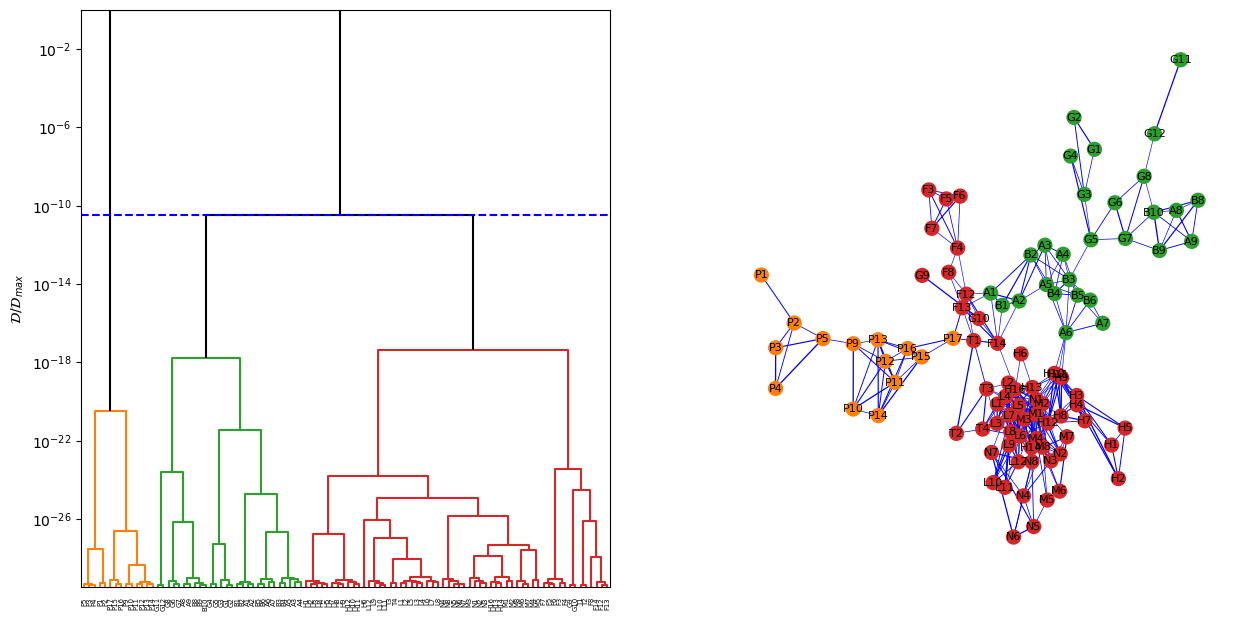

In [38]:
phase = 'taskLearn'
data_pat_phase = data_pat[phase]
data_pat_phase_ts = data_pat_phase['data']
fs = data_pat_phase['fs']
filter_order = data_pat_phase['filter_order']
custom_th = None
jump_num = 3
#
corr_mat = build_corr_network(
    data_pat_phase_ts,
    **correlation_protocol
)
Th, jumps = find_threshold_jumps(nx.from_numpy_array(corr_mat))
#
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
#
corr_mat_tmp = corr_mat.copy()
corr_mat_tmp[corr_mat_tmp < Th[jumps[jump_num]]] = 0
G, removed_nodes = get_giant_component_leftoff(nx.from_numpy_array(corr_mat_tmp))
labeldict = {k: v for k, v in all_labels.to_dict().items() if k not in removed_nodes}
#
spect, L, rho, Trho, tau = compute_laplacian_properties(G, tau=None)
dists = squareform(Trho)
lnkgM, label_list, _ = compute_normalized_linkage(dists, G, method='ward')
clTh, *_ = compute_optimal_threshold(lnkgM, scaling_factor=0.98)
clTh = custom_th or clTh
optimal_clusters = fcluster(lnkgM, t=clTh, criterion='distance')
#
node_list = list(G.nodes())
labels_for_dendro = [labeldict[n] for n in node_list]
#
# Dendrogram first (to get the leaf colors)
dendro = dendrogram(
    lnkgM,
    ax=ax[0],
    color_threshold=clTh,
    labels=labels_for_dendro,
    **kw_dentro
)
tmin = lnkgM[:, 2][0] * 0.8
tmax = lnkgM[:, 2][-1] * 1.01
ax[0].set_yscale('log')
ax[0].axhline(clTh, **kw_thline)
ax[0].set_ylim(tmin, tmax)
ax[0].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
#
widths = [G[u][v]['weight'] for u, v in G.edges()]
edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G.edges(data=True)]

# Get the leaf colors from dendrogram and map to nodes
leaf_label_colors = {lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[labeldict[n]] for n in G.nodes()]

print(G.nodes(), len(G.nodes()))

pos = nx.kamada_kawai_layout(G)

nx.draw(G, ax=ax[1],  width=widths, edge_color=edge_colors, 
        labels=labeldict,
        node_color=node_colors, pos=pos, **kw_draw_graph)
#
# 

### multiple per phase

In [65]:
# Cycle through phases and jump thresholds - individual plots
n_jumps = 10  # Number of first jumps to analyze

for phase_idx, phase in enumerate(phase_labels):
    print(f"Processing phase: {phase}")
    
    # Get data for this phase
    data_pat_phase = data_pat[phase]
    data_pat_phase_ts = data_pat_phase['data']
    fs = data_pat_phase['fs']
    
    # Build correlation network
    corr_mat = build_corr_network(
        data_pat_phase_ts,
        **correlation_protocol
    )
    Th, jumps = find_threshold_jumps(nx.from_numpy_array(corr_mat))
    
    for jump_idx in range(min(n_jumps, len(jumps))):
        print(f"  Processing jump {jump_idx}, threshold {Th[jumps[jump_idx]]:.3f}")
        
        # Create individual figure for this phase/threshold combination
        fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
        
        # Apply threshold
        corr_mat_tmp = corr_mat.copy()
        corr_mat_tmp[corr_mat_tmp < Th[jumps[jump_idx]]] = 0
        G, removed_nodes = get_giant_component_leftoff(nx.from_numpy_array(corr_mat_tmp))
        
        if len(G.nodes()) == 0:
            ax[0].text(0.5, 0.5, 'No nodes remaining', ha='center', va='center', transform=ax[0].transAxes)
            ax[1].text(0.5, 0.5, 'No nodes remaining', ha='center', va='center', transform=ax[1].transAxes)
            fig.suptitle(f'{patient} - {phase} - Jump {jump_idx} - Threshold {Th[jumps[jump_idx]]:.3f}')
            filename = f'{patient}_{phase}_jump{jump_idx:02d}_th{Th[jumps[jump_idx]]:.3f}.png'
            fig.savefig(path_figs / filename, dpi=150, bbox_inches='tight')
            plt.close(fig)
            continue
            
        labeldict = {k: v for k, v in all_labels.to_dict().items() if k not in removed_nodes}
        
        # Compute hierarchical clustering
        spect, L, rho, Trho, tau = compute_laplacian_properties(G, tau=None)
        dists = squareform(Trho)
        lnkgM, label_list, _ = compute_normalized_linkage(dists, G, method='ward')
        clTh, *_ = compute_optimal_threshold(lnkgM, scaling_factor=0.98)
        
        node_list = list(G.nodes())
        labels_for_dendro = [labeldict[n] for n in node_list]
        
        # Dendrogram (left panel)
        dendro = dendrogram(
            lnkgM,
            ax=ax[0],
            color_threshold=clTh,
            labels=labels_for_dendro,
            **kw_dentro
        )
        
        tmin = lnkgM[:, 2][0] * 0.8
        tmax = lnkgM[:, 2][-1] * 1.01
        ax[0].set_yscale('log')
        ax[0].axhline(clTh, **kw_thline)
        ax[0].set_ylim(tmin, tmax)
        ax[0].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
        ax[0].set_title('Dendrogram')
        
        # Network (right panel) with matching colors
        widths = [G[u][v]['weight'] for u, v in G.edges()]
        edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G.edges(data=True)]
        
        # Get the leaf colors from dendrogram and map to nodes
        leaf_label_colors = {lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])}
        
        # Map node colors based on dendrogram leaf colors
        node_colors = []
        for n in node_list:
            label = labeldict[n]
            if label in leaf_label_colors:
                node_colors.append(leaf_label_colors[label])
            else:
                node_colors.append('gray')  # Default color for unmapped nodes
        
        pos = nx.kamada_kawai_layout(G)
        nx.draw(G, ax=ax[1], width=widths, edge_color=edge_colors,
                labels=labeldict,
                node_color=node_colors, pos=pos, **kw_draw_graph)
        ax[1].set_title('Network')
        
        # Set overall title and save
        fig.suptitle(f'{patient} - {phase} - Jump {jump_idx} - Threshold {Th[jumps[jump_idx]]:.3f} - Nodes: {len(G.nodes())}', fontsize=14)
        
        filename = f'{patient}_{phase}_jump{jump_idx:02d}_th{Th[jumps[jump_idx]]:.3f}.png'
        fig.savefig(path_figs / filename, dpi=150, bbox_inches='tight')
        plt.close(fig)
        
        print(f"    Saved: {filename}")

print("All plots saved!")

Processing phase: rsPre
  Processing jump 0, threshold 0.280
  Processing jump 0, threshold 0.280
    Saved: Pat_02_rsPre_jump00_th0.280.png
  Processing jump 1, threshold 0.309
    Saved: Pat_02_rsPre_jump00_th0.280.png
  Processing jump 1, threshold 0.309
    Saved: Pat_02_rsPre_jump01_th0.309.png
  Processing jump 2, threshold 0.340
    Saved: Pat_02_rsPre_jump01_th0.309.png
  Processing jump 2, threshold 0.340
    Saved: Pat_02_rsPre_jump02_th0.340.png
  Processing jump 3, threshold 0.375
    Saved: Pat_02_rsPre_jump02_th0.340.png
  Processing jump 3, threshold 0.375
    Saved: Pat_02_rsPre_jump03_th0.375.png
  Processing jump 4, threshold 0.413
    Saved: Pat_02_rsPre_jump03_th0.375.png
  Processing jump 4, threshold 0.413
    Saved: Pat_02_rsPre_jump04_th0.413.png
  Processing jump 5, threshold 0.455
    Saved: Pat_02_rsPre_jump04_th0.413.png
  Processing jump 5, threshold 0.455
    Saved: Pat_02_rsPre_jump05_th0.455.png
  Processing jump 6, threshold 0.501
    Saved: Pat_02_rsPr

### multiple per phase, per band


Processing band: delta
  Processing phase: rsPre


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPre: 117 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 117 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 117 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPost: 117 nodes in giant component
  Saved: Pat_02_delta_cross_phase_jump00.png
  Saved: Pat_02_delta_cross_phase_jump00.png


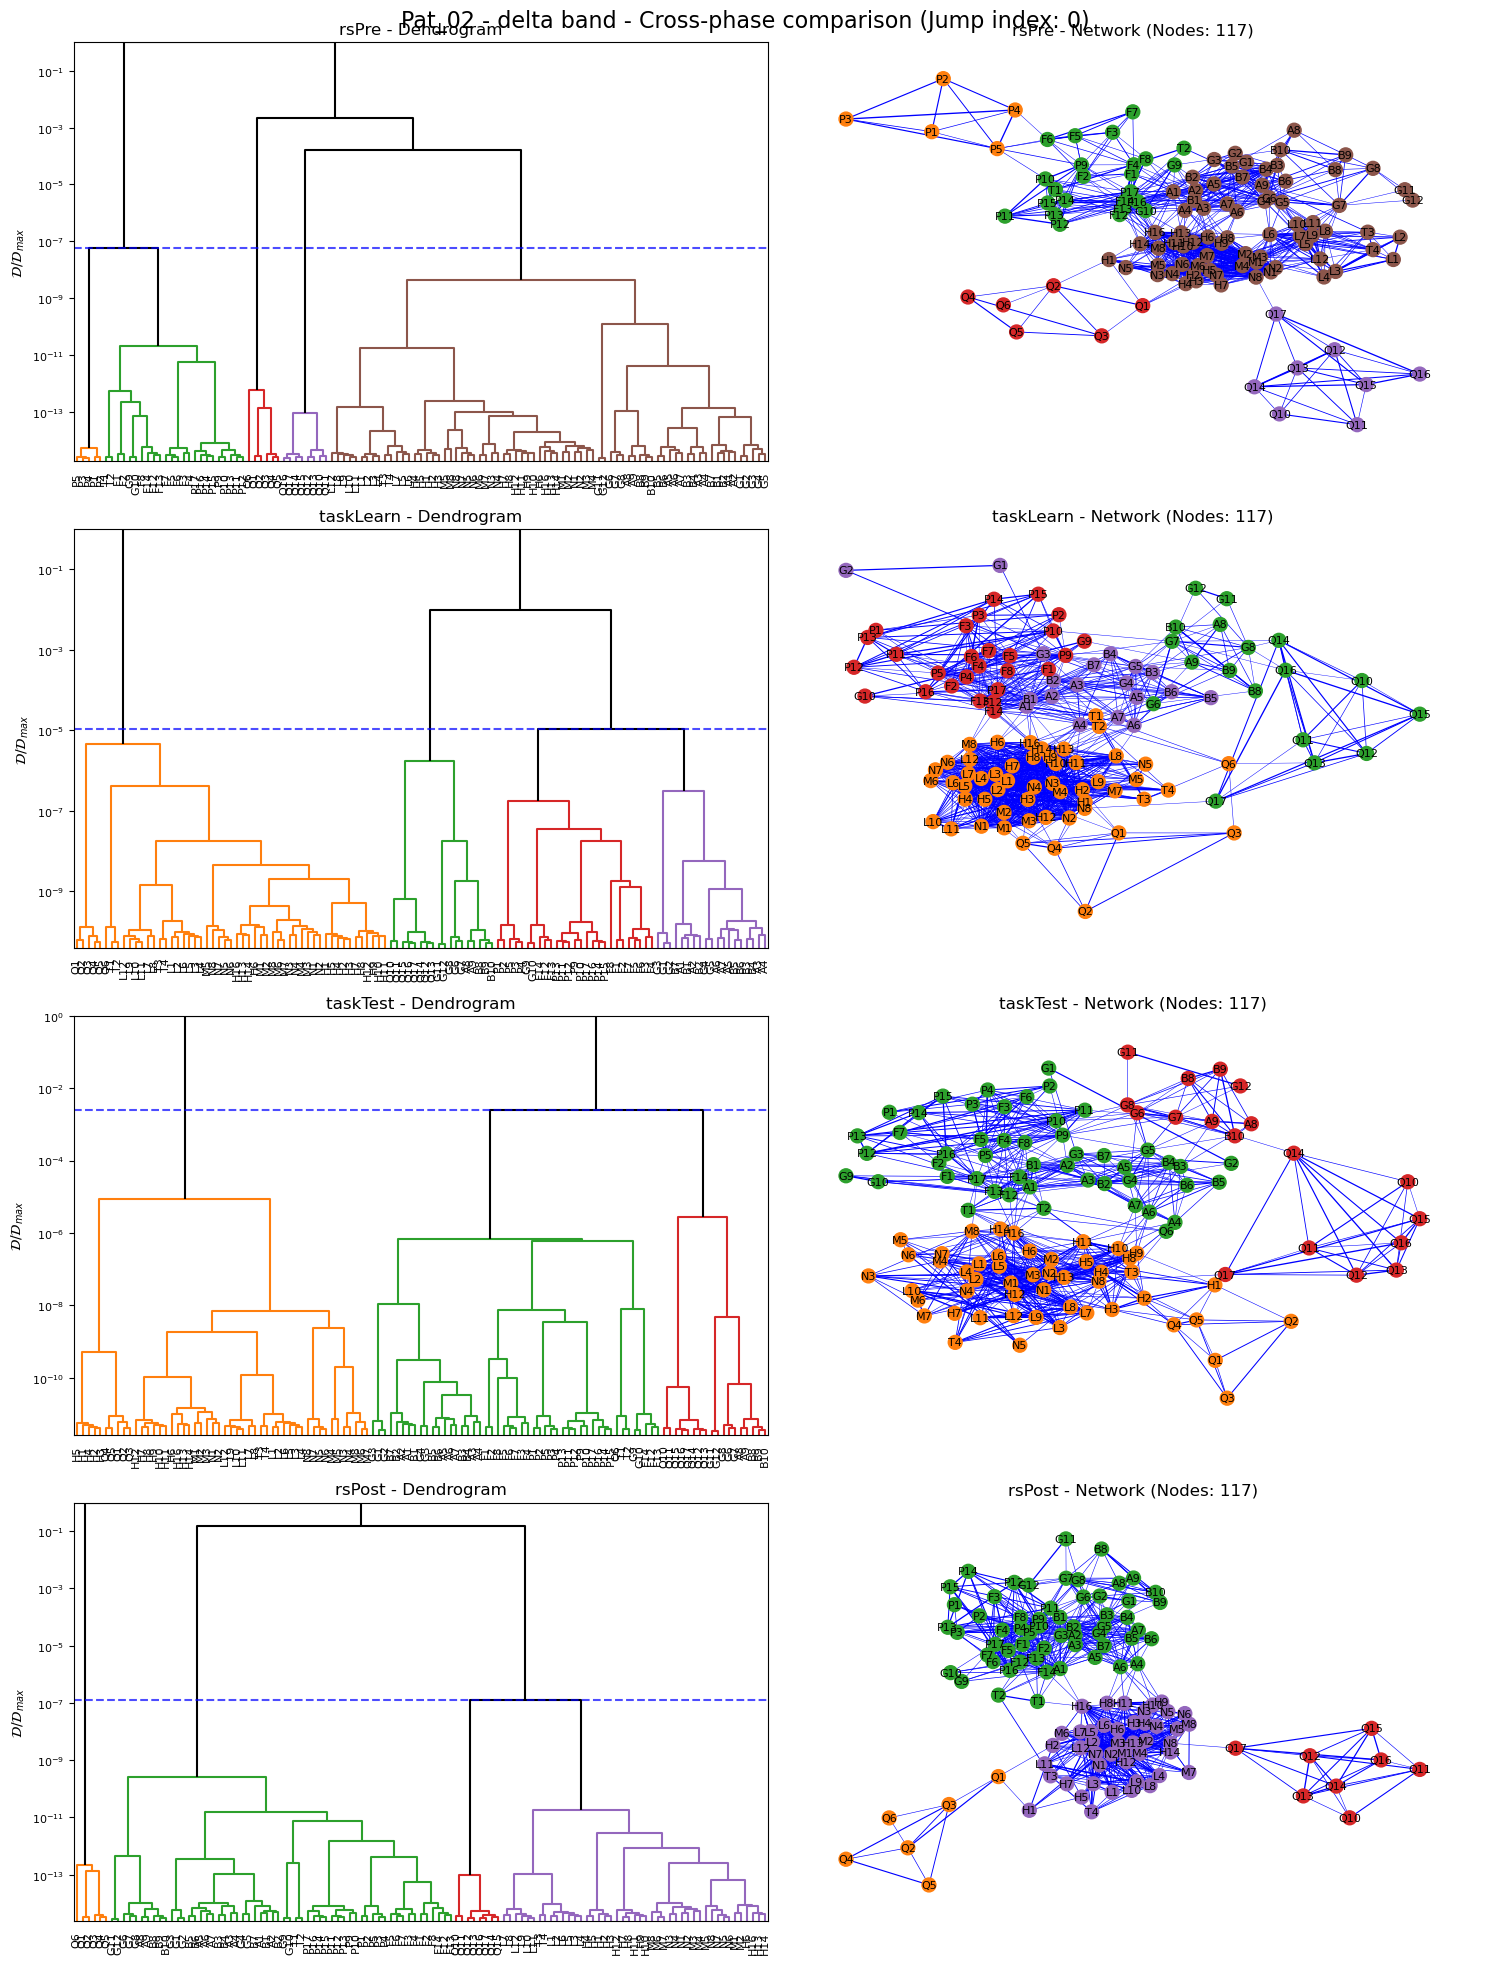


Processing band: theta
  Processing phase: rsPre


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPre: 117 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 117 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 117 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPost: 117 nodes in giant component
  Saved: Pat_02_theta_cross_phase_jump00.png
  Saved: Pat_02_theta_cross_phase_jump00.png


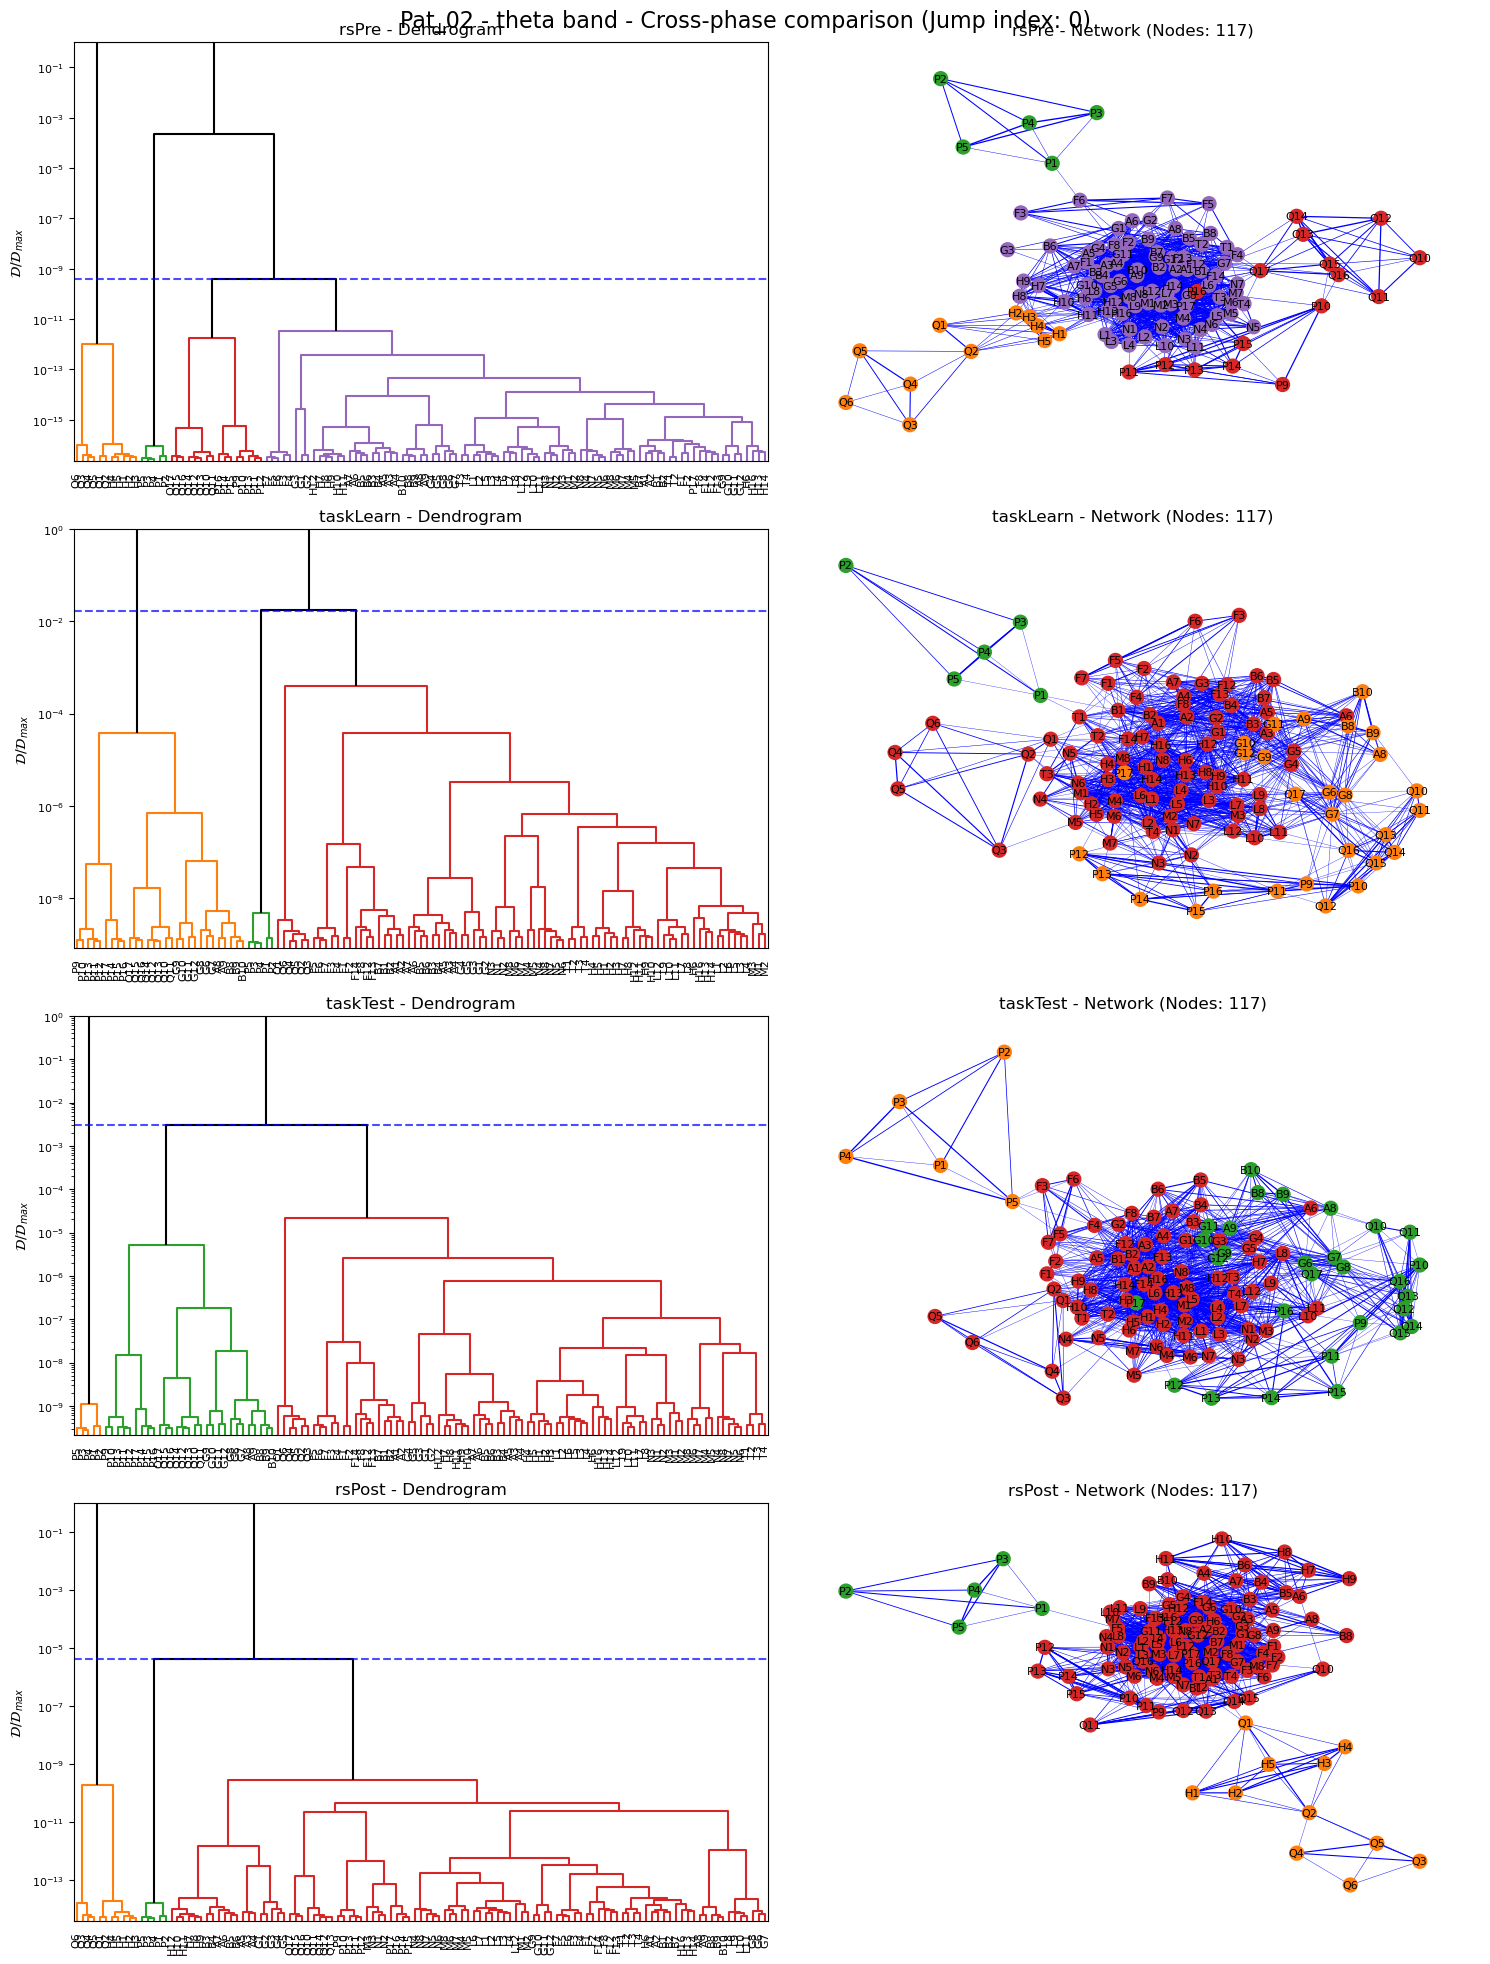


Processing band: alpha
  Processing phase: rsPre


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPre: 117 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 117 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 117 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPost: 117 nodes in giant component
  Saved: Pat_02_alpha_cross_phase_jump00.png
  Saved: Pat_02_alpha_cross_phase_jump00.png


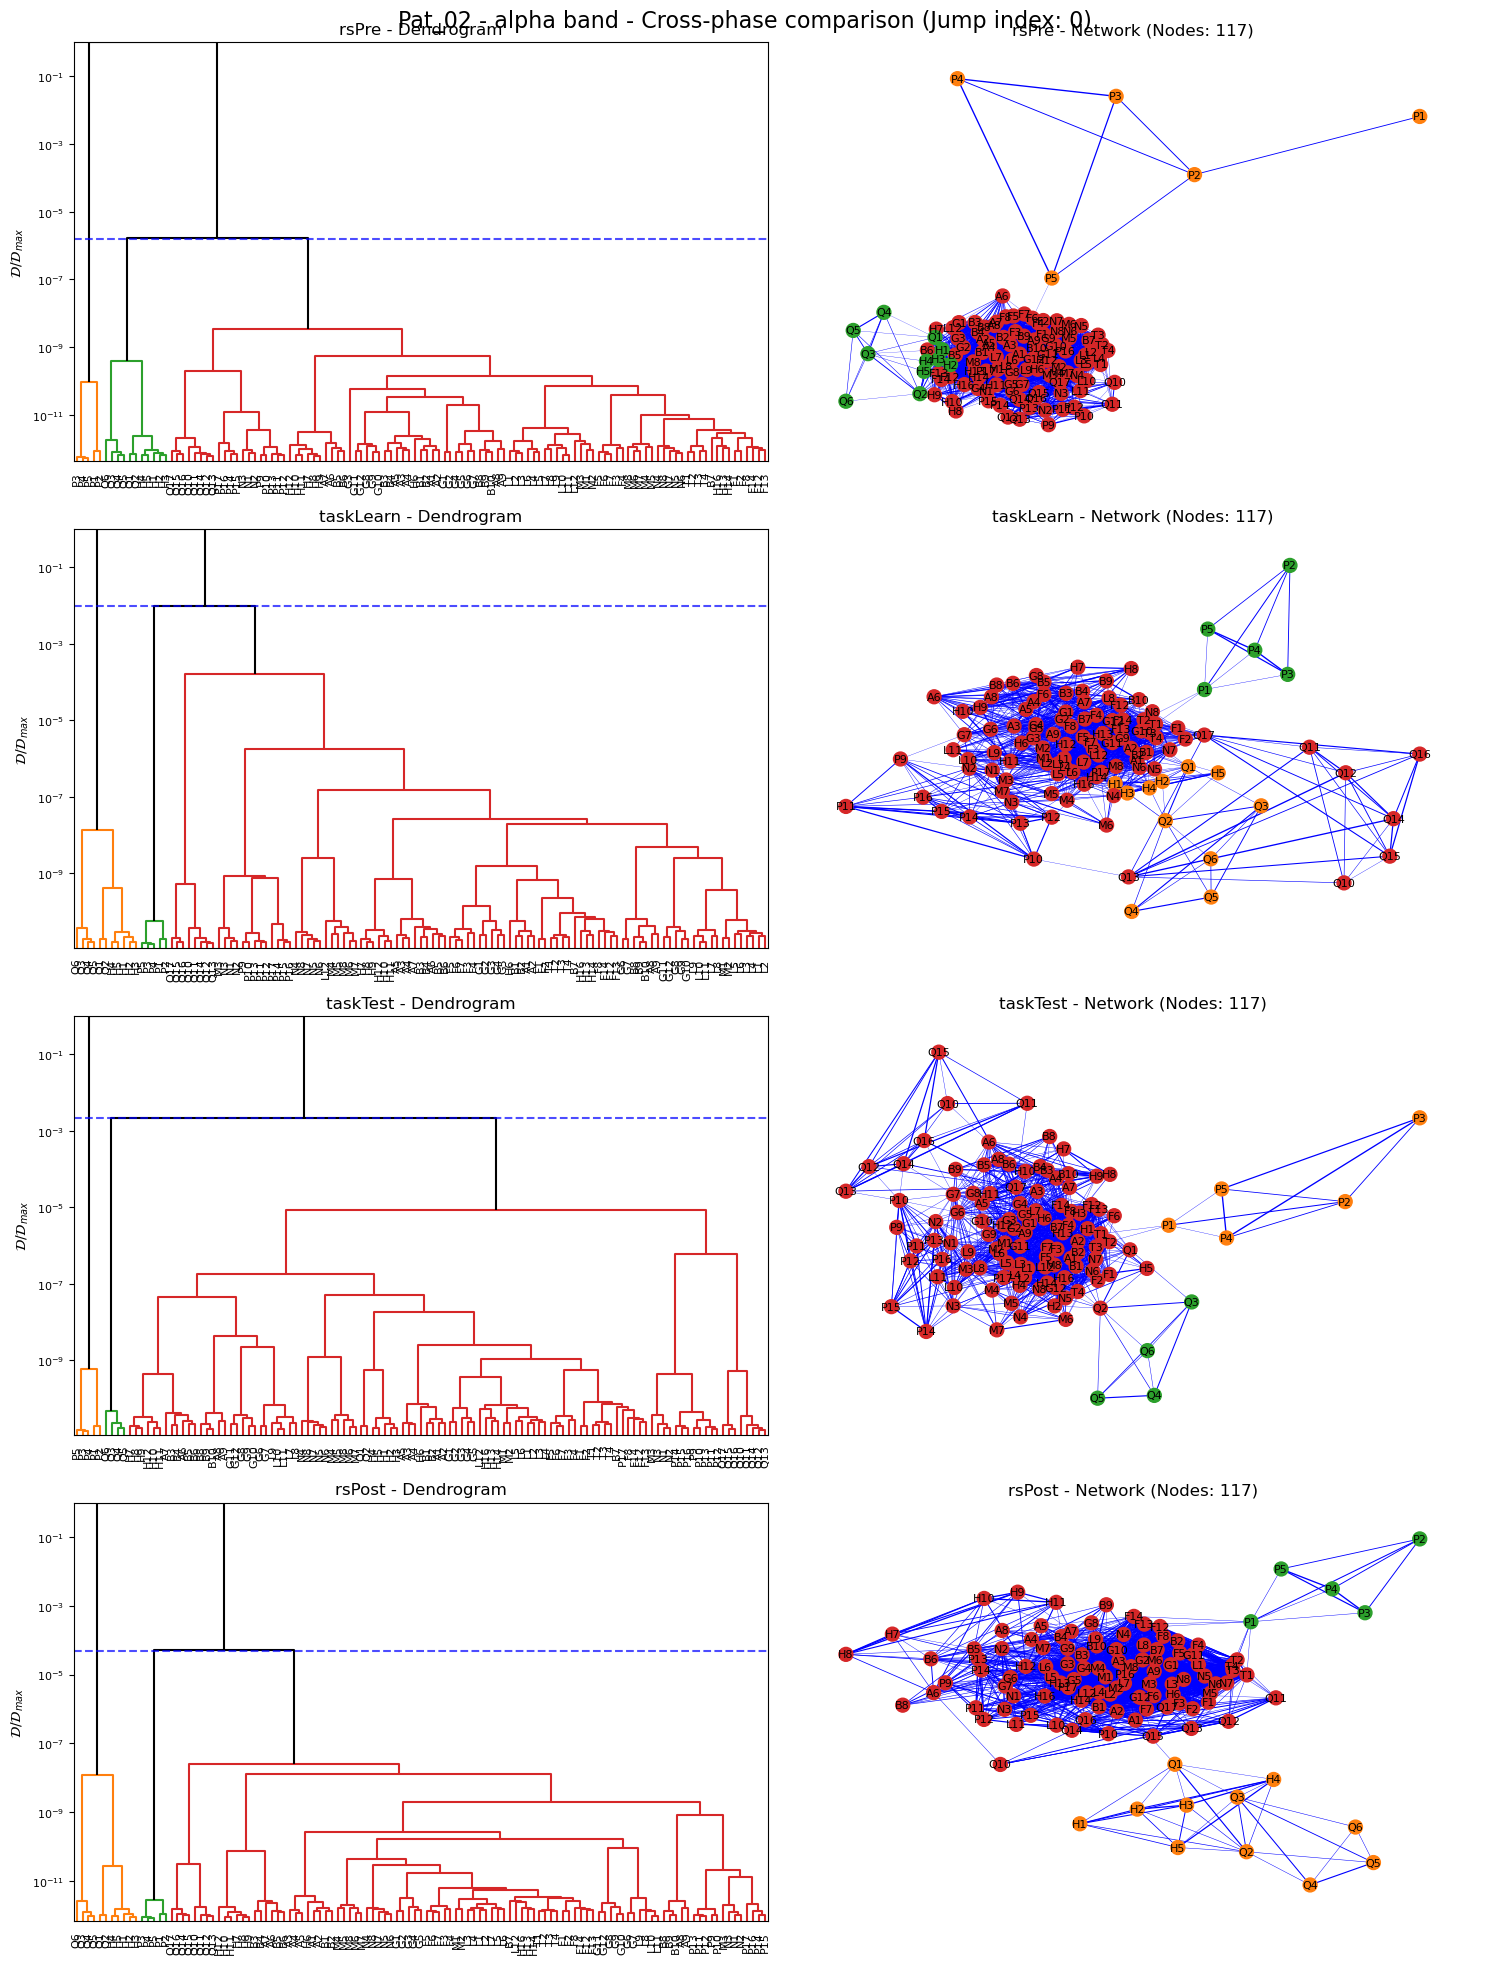


Processing band: beta
  Processing phase: rsPre


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPre: 117 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 117 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 117 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPost: 117 nodes in giant component
  Saved: Pat_02_beta_cross_phase_jump00.png
  Saved: Pat_02_beta_cross_phase_jump00.png


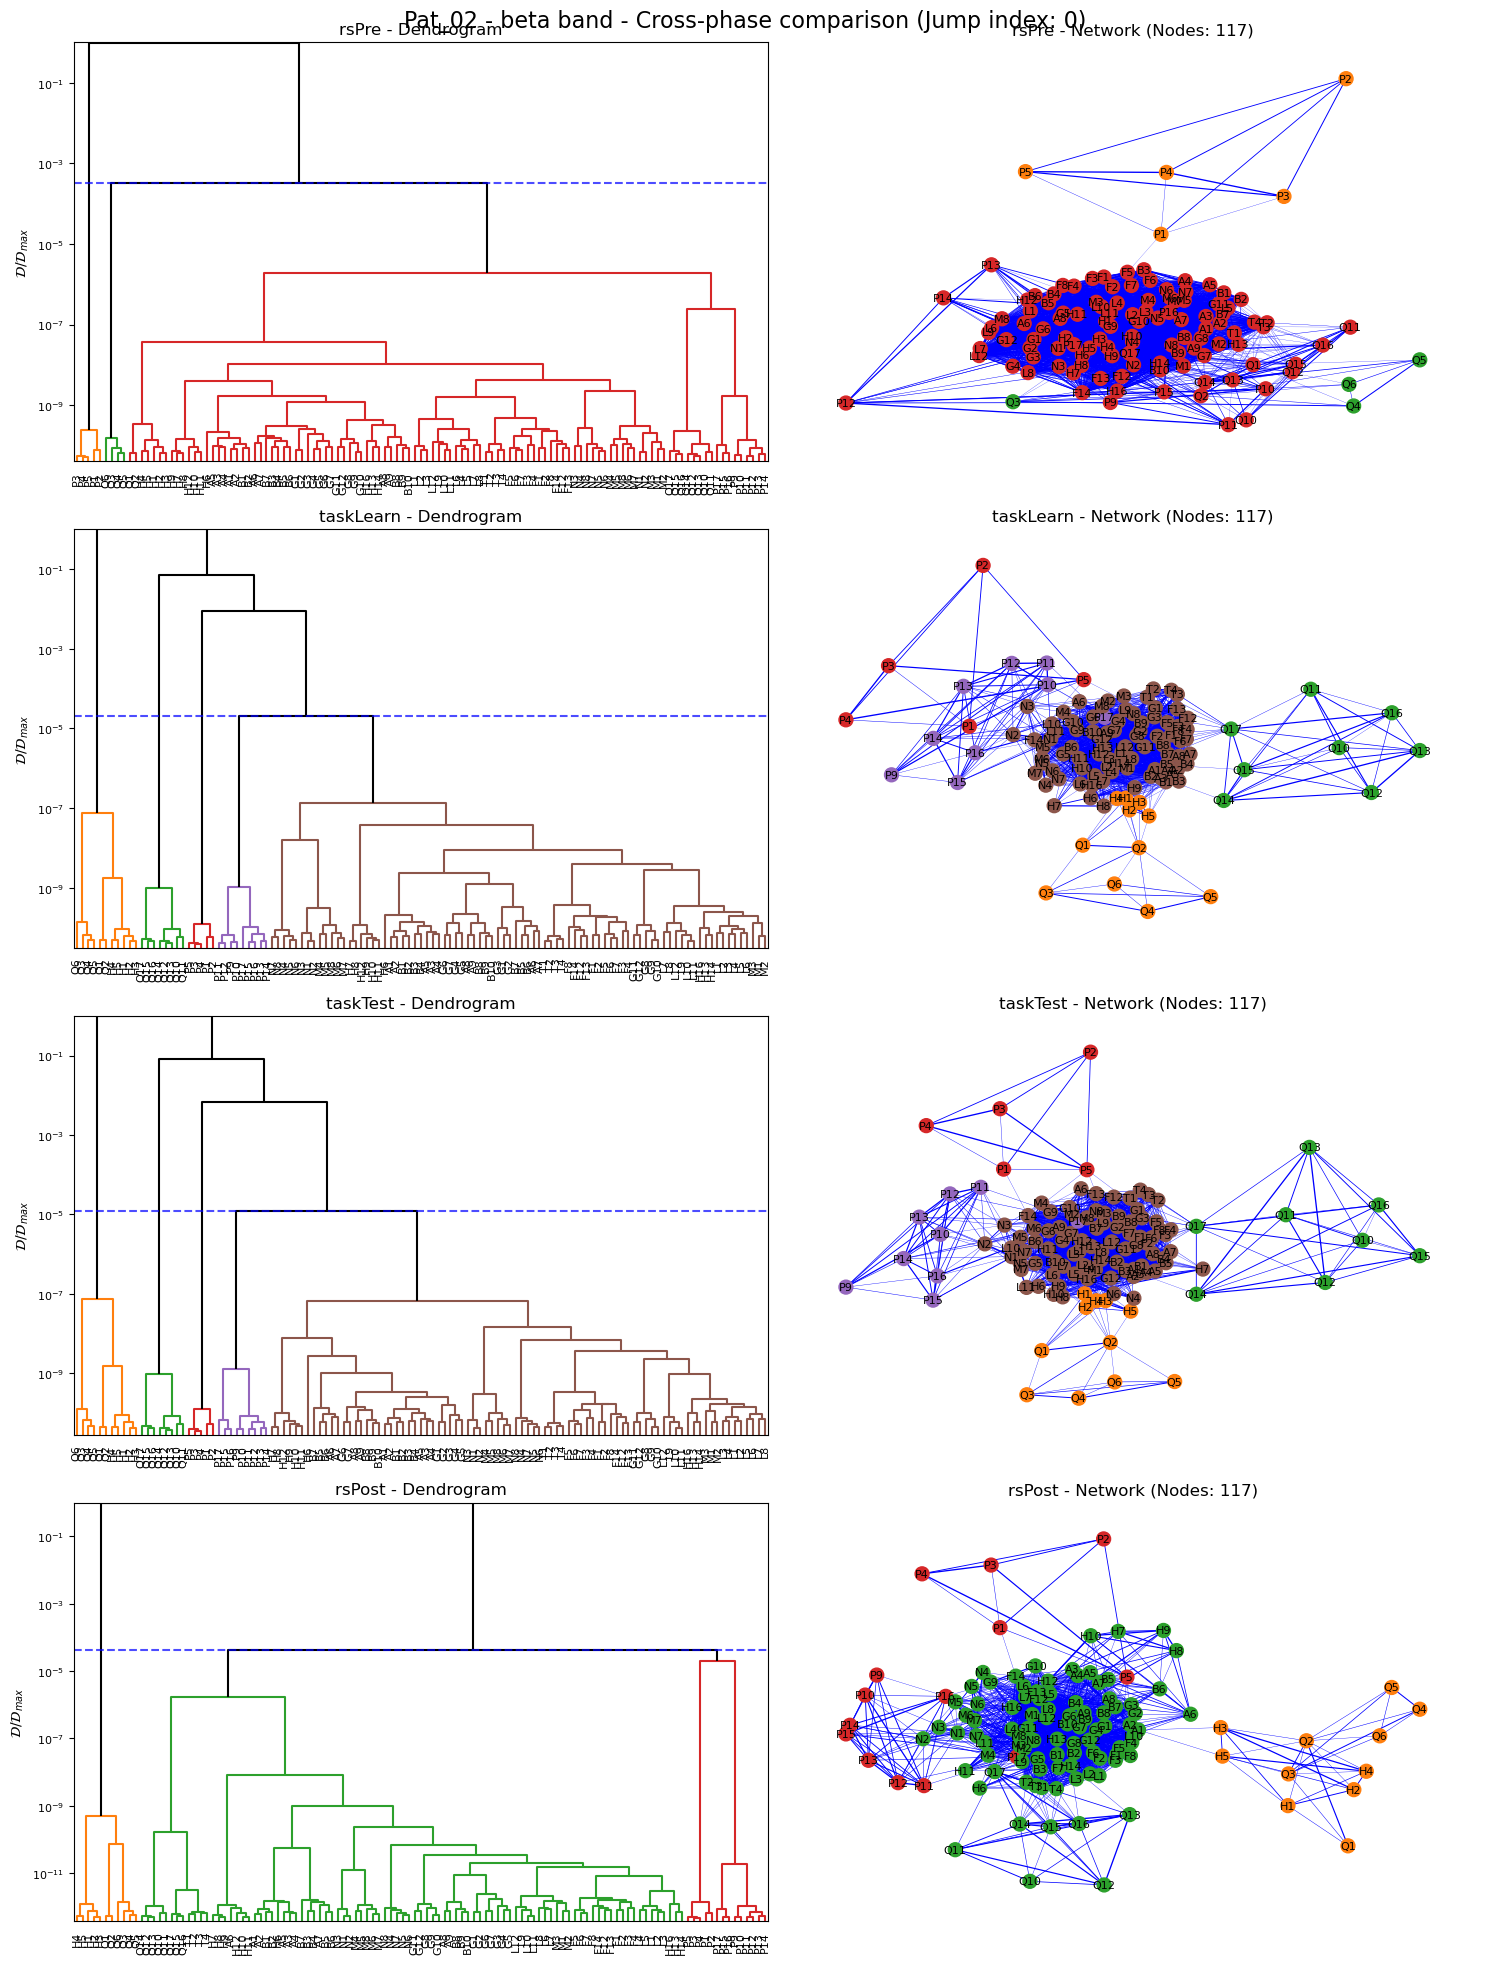


Processing band: low_gamma
  Processing phase: rsPre


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPre: 117 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 117 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 117 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPost: 117 nodes in giant component
  Saved: Pat_02_low_gamma_cross_phase_jump00.png
  Saved: Pat_02_low_gamma_cross_phase_jump00.png


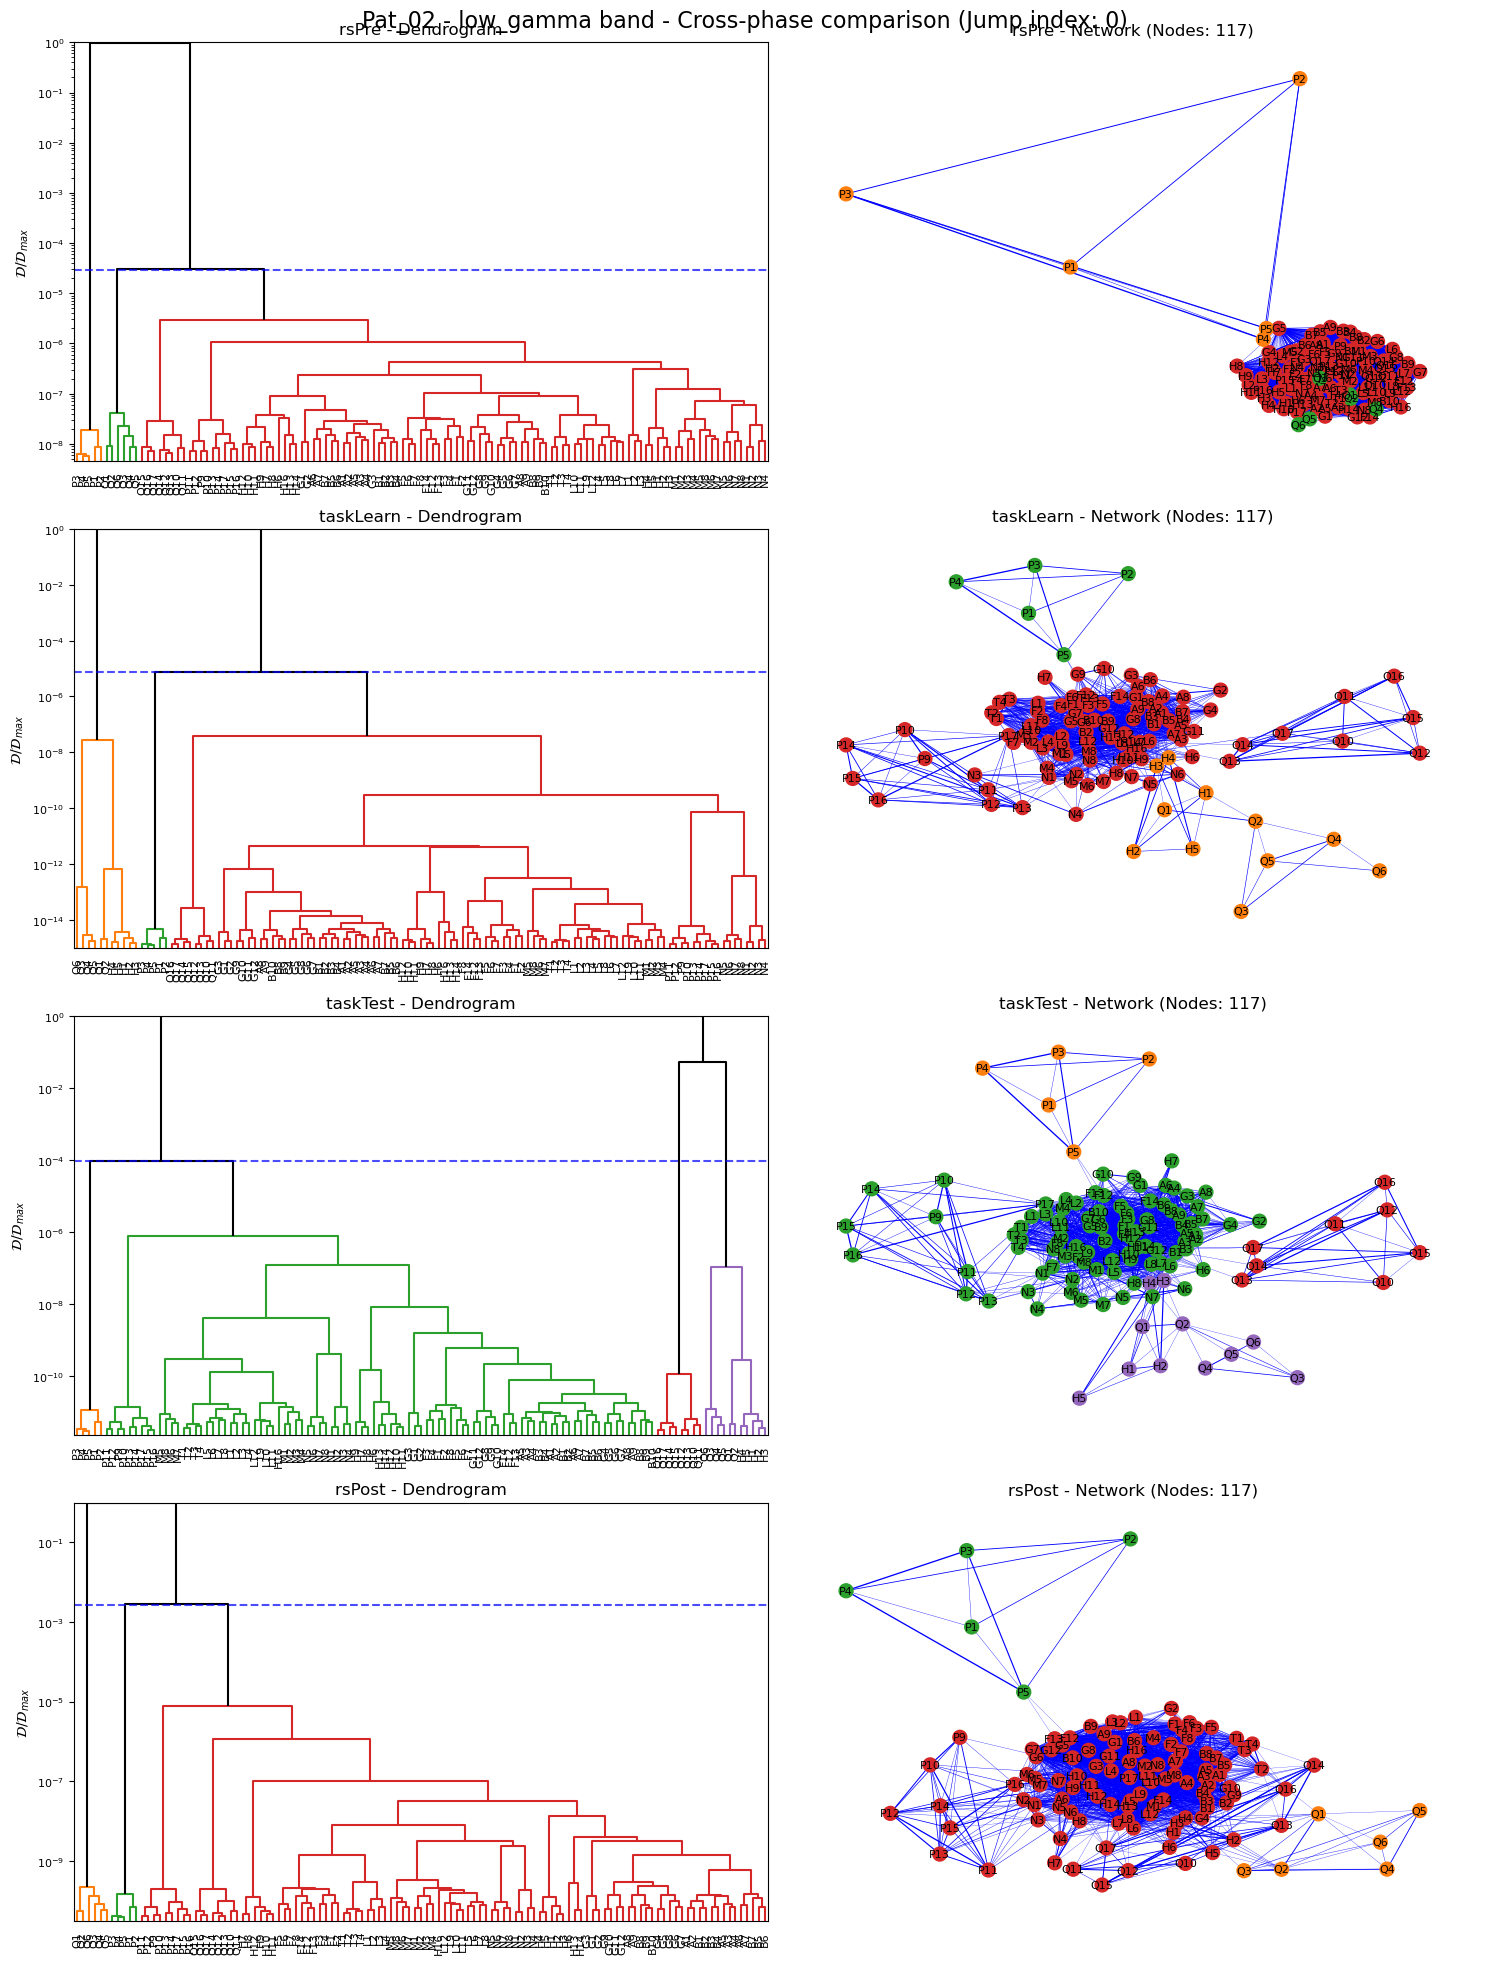


Processing band: high_gamma
  Processing phase: rsPre


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPre: 117 nodes in giant component
  Processing phase: taskLearn


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskLearn: 117 nodes in giant component
  Processing phase: taskTest


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    taskTest: 117 nodes in giant component
  Processing phase: rsPost


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

    rsPost: 117 nodes in giant component
  Saved: Pat_02_high_gamma_cross_phase_jump00.png
  Saved: Pat_02_high_gamma_cross_phase_jump00.png


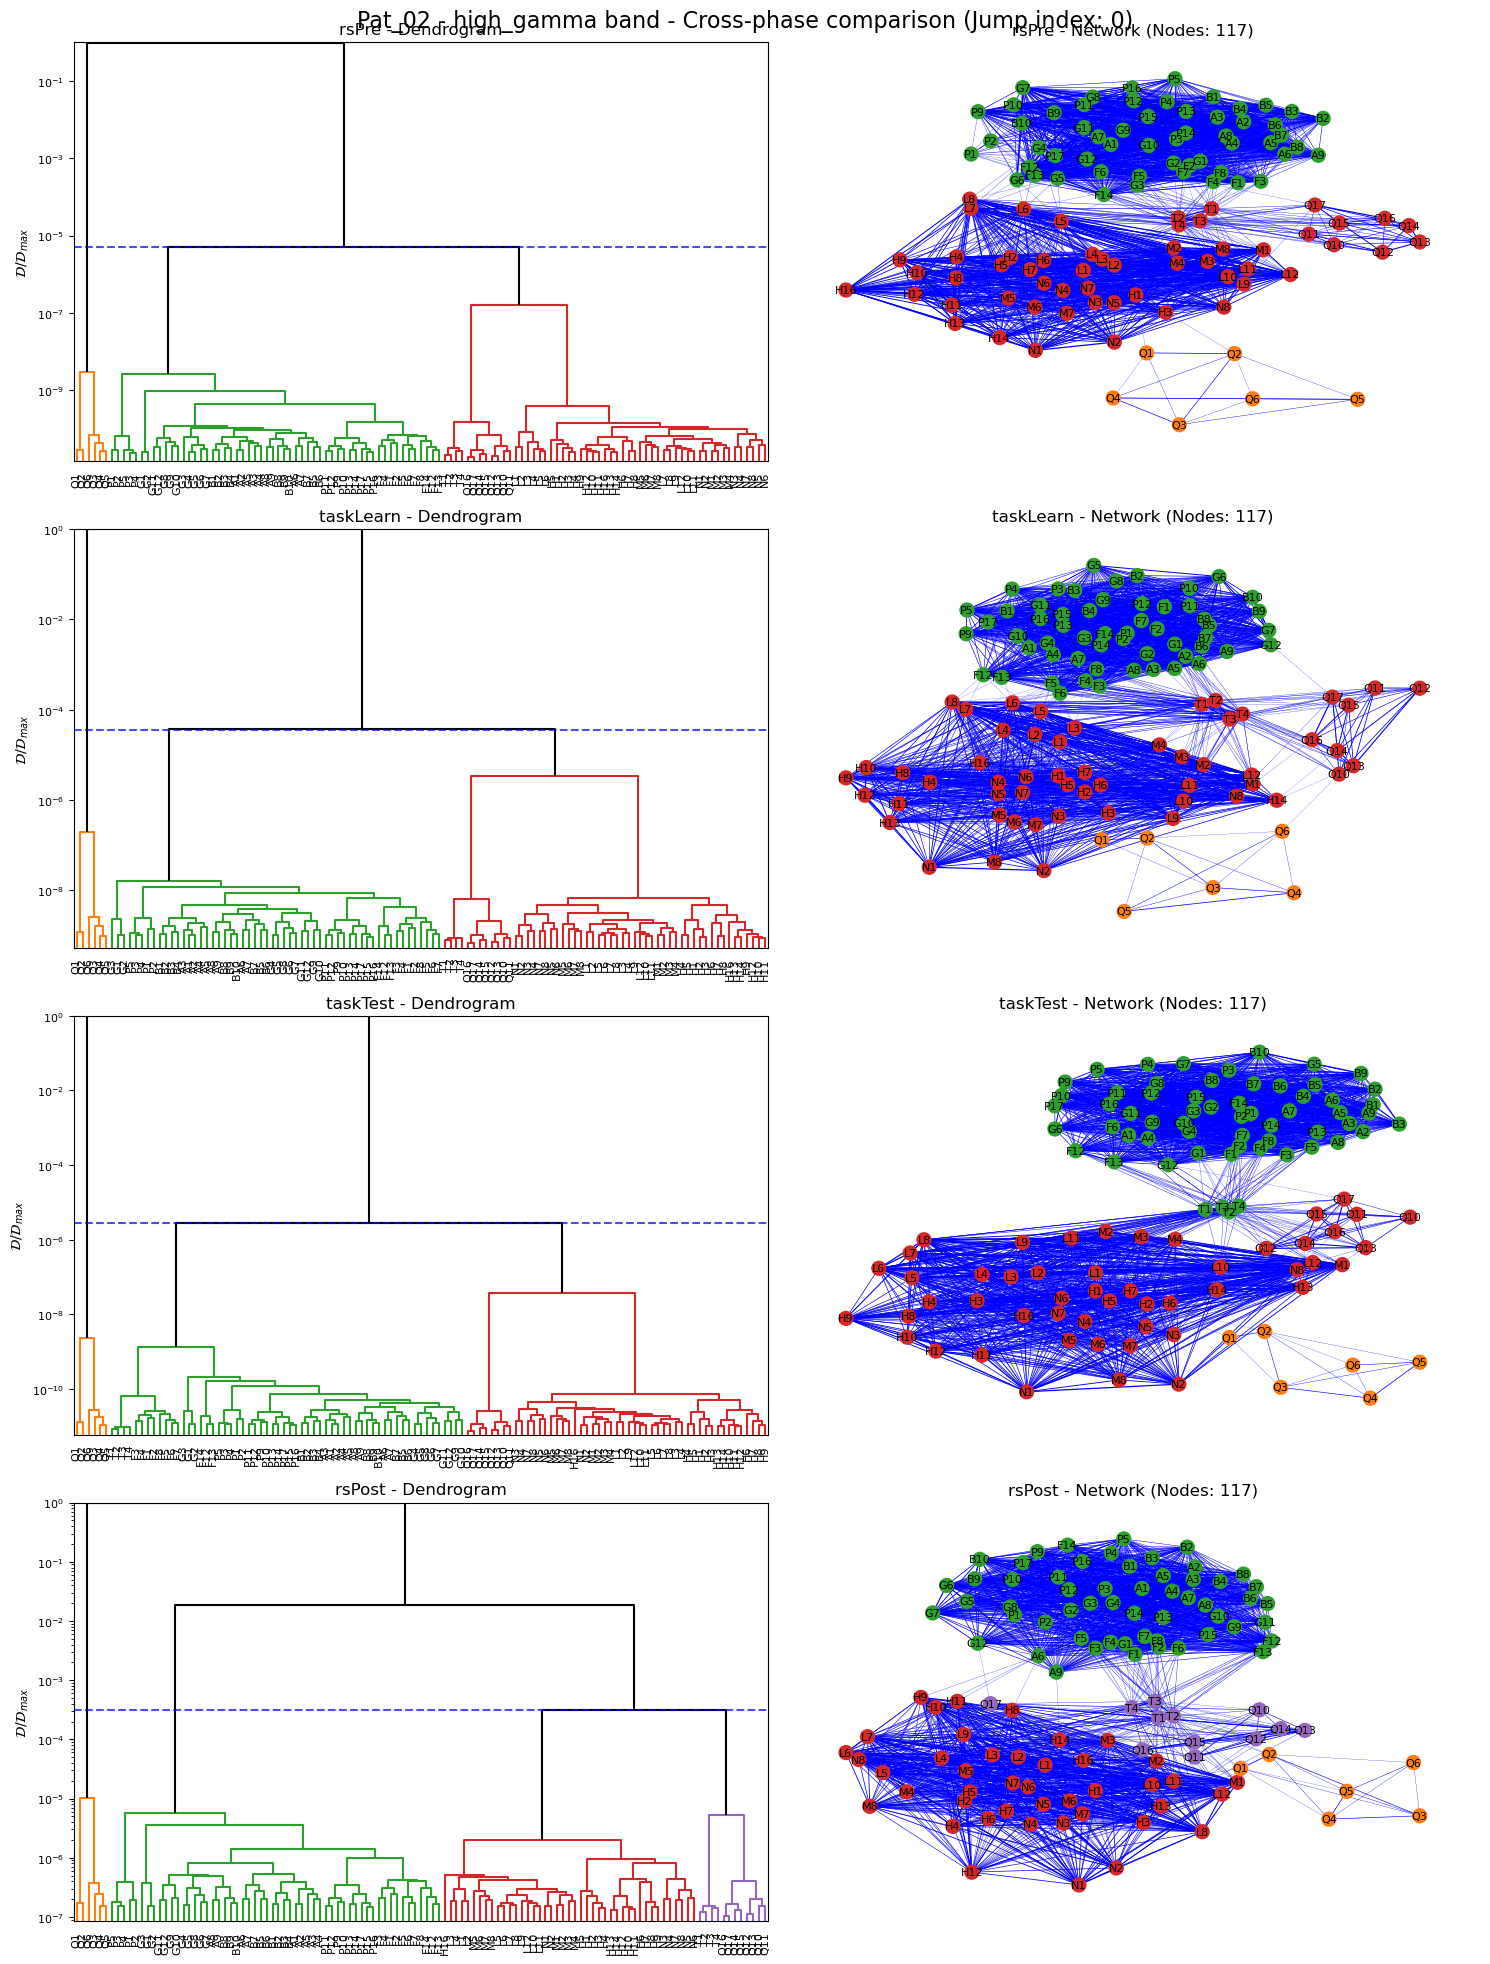


All band-phase grid plots completed!


In [ ]:
# Grid analysis: each band across all phases
# Format: rows = phases, columns = [dendrogram, network] for each band

jump_index_to_use = 0  # Which jump to use for thresholding

for band_name in BRAIN_BANDS.keys():
    print(f"\nProcessing band: {band_name}")
    
    # Create figure: rows = phases, columns = 2 (dendrogram + network)
    fig, axes = plt.subplots(len(phase_labels), 2, figsize=(15, 5*len(phase_labels)))
    
    if len(phase_labels) == 1:
        axes = axes.reshape(1, -1)  # Ensure 2D array for single phase
    
    for phase_idx, phase in enumerate(phase_labels):
        print(f"  Processing phase: {phase}")
        
        # Get data for this phase
        data_pat_phase = data_pat[phase]
        data_pat_phase_ts = data_pat_phase['data']
        fs = data_pat_phase['fs']
        
        # Build correlation matrices per band for this phase
        corr_mat_band = build_corrmat_perband(
            data_pat_phase_ts, 
            fs, 
            return_jump_info=False,
            apply_threshold_filtering=True,
            corr_network_params=correlation_protocol,
            jump_index=jump_index_to_use
        )
        
        # Get correlation matrix for current band
        corr_mat = corr_mat_band[band_name]
        
        # Create network and check if it has nodes
        G = nx.from_numpy_array(corr_mat)
        G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 0])
        G.remove_nodes_from(list(nx.isolates(G)))
        
        if len(G.nodes()) == 0:
            # Handle empty network
            axes[phase_idx, 0].text(0.5, 0.5, 'No nodes\nremaining', ha='center', va='center', transform=axes[phase_idx, 0].transAxes)
            axes[phase_idx, 1].text(0.5, 0.5, 'No nodes\nremaining', ha='center', va='center', transform=axes[phase_idx, 1].transAxes)
            axes[phase_idx, 0].set_title(f'{phase} - Dendrogram')
            axes[phase_idx, 1].set_title(f'{phase} - Network')
            continue
        
        # Get giant component
        G_giant, removed_nodes = get_giant_component_leftoff(G)
        
        if len(G_giant.nodes()) == 0:
            # Handle case where giant component is empty
            axes[phase_idx, 0].text(0.5, 0.5, 'No giant\ncomponent', ha='center', va='center', transform=axes[phase_idx, 0].transAxes)
            axes[phase_idx, 1].text(0.5, 0.5, 'No giant\ncomponent', ha='center', va='center', transform=axes[phase_idx, 1].transAxes)
            axes[phase_idx, 0].set_title(f'{phase} - Dendrogram')
            axes[phase_idx, 1].set_title(f'{phase} - Network')
            continue
        
        # Create filtered labels dictionary
        labeldict = {k: v for k, v in all_labels.to_dict().items() if k not in removed_nodes}
        
        # Compute hierarchical clustering
        spect, L, rho, Trho, tau = compute_laplacian_properties(G_giant, tau=None)
        dists = squareform(Trho)
        lnkgM, label_list, _ = compute_normalized_linkage(dists, G_giant, method='ward')
        clTh, *_ = compute_optimal_threshold(lnkgM, scaling_factor=0.98)
        
        node_list = list(G_giant.nodes())
        labels_for_dendro = [labeldict[n] for n in node_list]
        
        # Dendrogram (left column)
        dendro = dendrogram(
            lnkgM,
            ax=axes[phase_idx, 0],
            color_threshold=clTh,
            labels=labels_for_dendro,
            above_threshold_color='k',
            leaf_font_size=6,
            orientation='top'
        )
        
        tmin = lnkgM[:, 2][0] * 0.8
        tmax = lnkgM[:, 2][-1] * 1.01
        axes[phase_idx, 0].set_yscale('log')
        axes[phase_idx, 0].axhline(clTh, color='b', linestyle='--', alpha=0.7)
        axes[phase_idx, 0].set_ylim(tmin, tmax)
        axes[phase_idx, 0].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
        axes[phase_idx, 0].set_title(f'{phase} - Dendrogram')
        axes[phase_idx, 0].tick_params(axis='x', labelsize=8)
        axes[phase_idx, 0].tick_params(axis='y', labelsize=8)
        
        # Network (right column) with matching colors
        widths = [G_giant[u][v]['weight'] for u, v in G_giant.edges()]
        edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G_giant.edges(data=True)]
        
        # Get the leaf colors from dendrogram and map to nodes
        leaf_label_colors = {lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])}
        
        # Map node colors based on dendrogram leaf colors
        node_colors = []
        for n in node_list:
            label = labeldict[n]
            if label in leaf_label_colors:
                node_colors.append(leaf_label_colors[label])
            else:
                node_colors.append('gray')  # Default color for unmapped nodes
        
        pos = nx.kamada_kawai_layout(G_giant)
        nx.draw(G_giant, ax=axes[phase_idx, 1], width=widths, edge_color=edge_colors,
                labels=labeldict, node_color=node_colors, pos=pos, 
                node_size=100, font_size=8, with_labels=True)
        axes[phase_idx, 1].set_title(f'{phase} - Network (Nodes: {len(G_giant.nodes())})')
        
        print(f"    {phase}: {len(G_giant.nodes())} nodes in giant component")
    
    # Set overall title and save
    fig.suptitle(f'{patient} - {band_name} band - Cross-phase comparison (Jump index: {jump_index_to_use})', fontsize=16)
    plt.tight_layout()
    
    # Save the figure
    filename = f'{patient}_{band_name}_cross_phase_jump{jump_index_to_use:02d}.pdf'
    fig.savefig(path_figs / filename, bbox_inches='tight')
    print(f"  Saved: {filename}")
    
    plt.show()

print("\nAll band-phase grid plots completed!")